In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import F1Score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [56]:
df_train = pd.read_csv("../Data/Train.csv", index_col=0)
df_val = pd.read_csv("../Data/Val.csv", index_col=0)

In [17]:
df_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.97947,0.463812,0.374437,0.378025,0.145534,0.211876,-1.513639,-0.120963,-0.050907,-0.885320,0.510405,0.965312,1.666965,-1.649821,1.125396,0.050004,3
1,-1.02096,0.463812,-2.670680,0.378025,0.145534,0.211876,0.646890,1.109698,1.965849,-0.566264,-0.525460,1.077507,0.396407,-0.026192,-0.007113,-1.090236,5
2,0.97947,0.463812,0.374437,0.378025,0.145534,0.211876,0.646890,-0.120963,-0.361178,0.603606,1.137376,-1.166375,0.396407,-0.026192,0.806878,0.177803,3
3,-1.02096,0.463812,0.374437,-2.769095,0.145534,0.211876,-1.513639,-0.120963,0.879903,-0.991672,-1.426947,-0.680201,1.551460,-0.026192,-0.219459,-1.090236,0
4,0.97947,0.463812,0.374437,0.378025,0.145534,0.211876,-1.513639,1.109698,-1.136853,1.348068,-1.066429,0.292148,1.538626,-0.026192,1.172584,-0.336715,0


In [18]:
scaler = pickle.load(open('../tools/scaler.sav', 'rb'))
targ_enc = pickle.load(open('../tools/targ_enc.sav', 'rb'))
class_weights = pickle.load(open('../tools/class_weights.sav', 'rb'))

In [25]:
X_train = df_train.copy()
y_train= X_train.pop("NObeyesdad")

X_val = df_val.copy()
y_val= X_val.pop("NObeyesdad")

X_test = df_test.copy()
y_test = X_test.pop("NObeyesdad")

In [20]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [54]:
def model_cross_val():
    model = Sequential()
    model.add(InputLayer(shape=(X_train.shape[1],)))
    model.add(Dense(72, activation='relu', bias_regularizer=L2(0.1)))
    model.add(Dropout(0.35))
    model.add(Dense(7, activation ='softmax'))
    model.compile(optimizer=Adam(learning_rate = 1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
cv_scores = []
histories = []
for train_idx, val_idx in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx],X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx],y_train.iloc[val_idx]

    model = model_cross_val()
    history = model.fit(X_fold_train, y_fold_train, epochs=150, verbose=0)
    val_loss, val_acc = model.evaluate(X_fold_train, y_fold_train, verbose=0)
    cv_scores.append(val_acc)
    histories.append(history)

print("Mean_acc: " + str(np.mean(cv_scores)))

Mean_acc: 0.989794236421585


In [51]:
cv_scores

[0.981893002986908,
 0.9876543283462524,
 0.990123450756073,
 0.9827160239219666,
 0.9868312478065491,
 0.990123450756073,
 0.9909465312957764,
 0.9860082268714905,
 0.9851852059364319,
 0.9909465312957764]

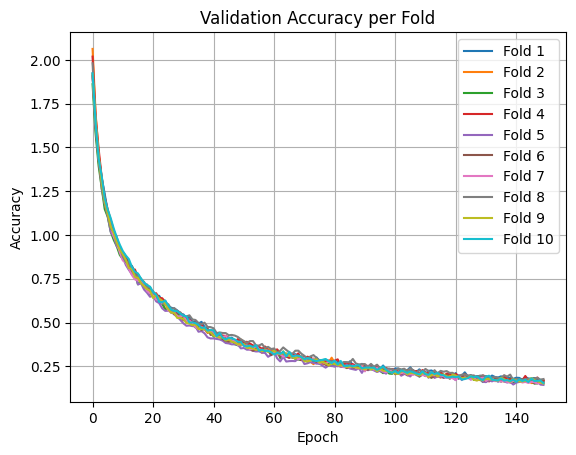

In [ ]:
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=f'Fold {i+1}')

plt.title('Validation loss per Fold')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

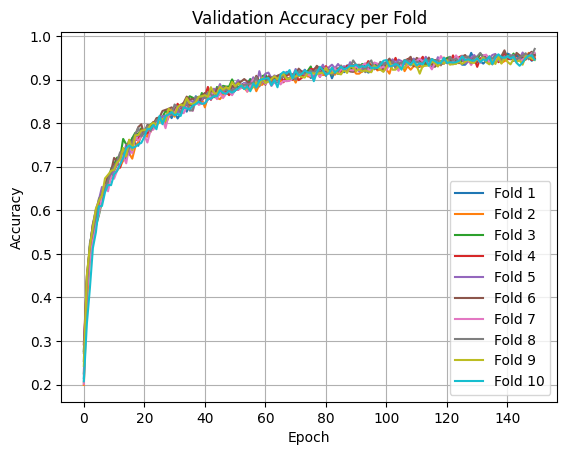

In [57]:
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=f'Fold {i+1}')

plt.title('Validation Accuracy per Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
model.save("../Model/obes_predictor.keras")